# Step 1: Imports and Setup

In [365]:
#!pip install roboflow

# original images
#from roboflow import Roboflow
#rf = Roboflow(api_key="odKT1WyVSQ7iL8vb5eeU")
#project = rf.workspace("elteikai90").project("palm-trees-lfhgj")
#dataset = project.version(3).download("coco-segmentation")


# augmented images
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="odKT1WyVSQ7iL8vb5eeU")
project = rf.workspace("elteikai90").project("palm-trees-lfhgj")
dataset = project.version(2).download("coco-segmentation")


58437.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Palm-Trees-2 in coco-segmentation:: 100%|██████████| 159/159 [00:00<00:00, 2006.69it/s]


# Step 1: Imports and Setup

Instead of manually crafting diagrams I decided to use torchvision's built in functions to visualize the data. This is a good way to get a feel for the data and to make sure that the data is being loaded correctly.

In [366]:
import os, random, copy, json, requests
import numpy as np
import torch
import torch.utils.data
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import v2 as T
from torchvision.utils import make_grid, draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.functional as F
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib import patches, text
from PIL import Image

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')

device: cpu


# Step 1.1: Helpers for visualizastion

In [367]:
top = 0
left = 1
bottom = 2
right = 3


def calculate_iou(bbox_a, bbox_b):
    yA = torch.max(bbox_a[:, top], bbox_b[:, top])
    xA = torch.max(bbox_a[:, left], bbox_b[:, left])

    yB = torch.min(bbox_a[:, bottom], bbox_b[:, bottom])
    xB = torch.min(bbox_a[:, right], bbox_b[:, right])

    interArea = (xB - xA) * (yB - yA)

    mask_a = (xB - xA) > 0
    mask_b = (yB - yA) > 0

    no_intersect_mask = (mask_a & mask_b) ^ 1

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (bbox_a[:, top] - bbox_a[:, bottom]) * (bbox_a[:, left] - bbox_a[:, right])
    boxBArea = (bbox_b[:, top] - bbox_b[:, bottom]) * (bbox_b[:, left] - bbox_b[:, right])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area

    iou = interArea.float() / (boxAArea + boxBArea - interArea).float()

    iou[no_intersect_mask] = 0

    # return the intersection over union value
    return iou


def img_to_np(img):
    img = img.cpu().numpy()
    img = np.copy(img)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)

    return img

    
def add_bbox(ax, bbox, color, alpha=1, text=""):
    top, left, width, height = bbox

    # Create a rectangle patch and add it to the axis
    rect = patches.Rectangle((left, top), width, height, linewidth=2, edgecolor=color, facecolor='none', alpha=alpha)
    ax.add_patch(rect)
    
    ax.text(
        left,
        top,
        text,
        fontsize=12,
        bbox=dict(
            boxstyle="square",
            fc=color,
        )
    )
    
def visualize_anchors(ax, anchors):
    for a in anchors:
        add_bbox(ax, torch.round(a).long(), [1.0, 1.0, 1.0], 0.2)
        
def visualize_rpn(ax, nms_reg, nms_cls, img, color=[1.0, 1.0, 1.0], draw_all=False):
    np_img = img_to_np(img)

    for r, c in zip(nms_reg, nms_cls):
        if c >= 0.5 or draw_all:
            add_bbox(ax, r, color=color, text="c={:.2f}".format(c))

            
def visualize_rcnn(ax, rcnn_reg, rcnn_cls, color_map):
    for rcnn_r, rcnn_c in zip(rcnn_reg, rcnn_cls):
        cls, index = torch.max(rcnn_c, dim=0)
        
        if index == 0:
            continue
        
        cls_color = color_map[0]
        if int(index) in color_map:
            cls_color = color_map[int(index)]

        add_bbox(ax, rcnn_r, color=cls_color, text="class={}: {:.2f}".format(index, cls))


# Step 2: Define the Dataset Class

It needs to create a dataset class that can read images and their corresponding annotations from the COCO format.

In [368]:
class PalmTreesDataset(CocoDetection):
    def __init__(self, root, annFile, transforms=None):
        super(PalmTreesDataset, self).__init__(root, annFile)
        self.transforms = transforms

        ids = self.coco.getCatIds()
        le = LabelEncoder()
        le.fit(ids)
        self.le = le

    def __getitem__(self, idx):
        item = super(PalmTreesDataset, self).__getitem__(idx)
        image = item[0]
        target = item[1]

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

# Step 3: Define Transformations

Define the transformations for the images. I have already introduced some augmentation with Roboflow.
> The example implemented a random flip, I use a built-in method from torchvision.

In [369]:
def get_transform(train):
    transforms = []
    #if train:
    #    transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToImage())
    return T.Compose(transforms)


# Step 4: Load the Data

Load the data using the custom dataset class.

In [370]:
BATCH_SIZE=16

# Paths to the data
train_dir = f'{dataset.location}/train'
train_ann = f'{dataset.location}/train/_annotations.coco.json'
valid_dir = f'{dataset.location}/valid'
valid_ann = f'{dataset.location}/valid/_annotations.coco.json'
test_dir = f'{dataset.location}/test'
test_ann = f'{dataset.location}/test/_annotations.coco.json'

# Datasets
dataset_train = PalmTreesDataset(train_dir, train_ann, get_transform(train=True))
dataset_valid = PalmTreesDataset(valid_dir, valid_ann, get_transform(train=False))
dataset_test = PalmTreesDataset(test_dir, valid_ann, get_transform(train=False))

# Data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print("\n======================\n")
print(f'train size: {len(dataset_train)}')
print(f'valid size: {len(dataset_valid)}')
print(f'test size: {len(dataset_test)}')

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


train size: 132
valid size: 13
test size: 13


# Show some images from the dataset

I found `torchvision.utils.make_grid` clumsy, so I wrote my own function to display the images.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


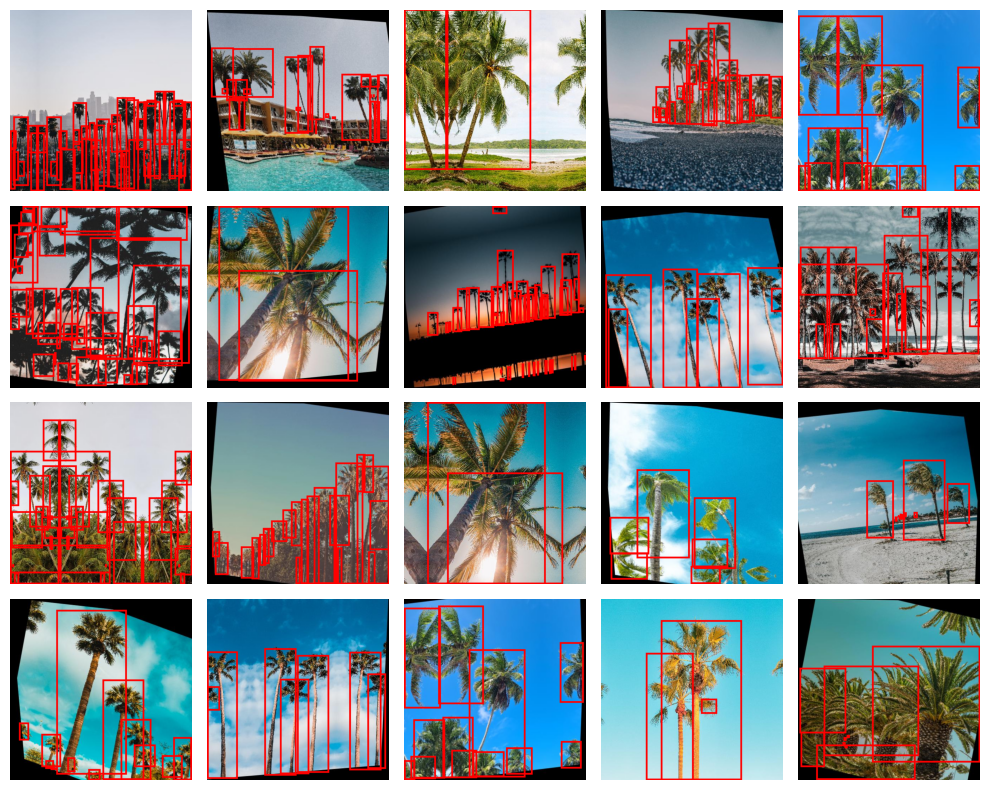

In [375]:
num_images = 20  # Total number of images to display
num_columns = 5  # Number of columns in the grid
num_rows = num_images // num_columns + (num_images % num_columns > 0)  # Calculate the number of rows needed

# Create a figure with the specified number of subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the dataset and display each image
for i, (image, targets) in enumerate(dataset_train):
    if i >= num_images:
        break  # Stop after displaying the desired number of images

    image = image.detach()
    img=torch.tensor(image*255,dtype=torch.uint8)

    bboxs=[target['bbox'] for target in targets]
    bboxs=[[box[0],box[1],box[0]+box[2],box[1]+box[3]] for box in bboxs]
    boxes = torch.tensor(bboxs, dtype=torch.float)
    colors = ["red"] * len(boxes)
    #print(boxs)
    annotated_image = draw_bounding_boxes(image=img, boxes=boxes, colors=colors, width=5)

    # Display the image in the corresponding subplot
    ax = axes[i]
    ax.imshow(F.to_pil_image(annotated_image))
    ax.axis('off')  # Hide the axes

# If there are any empty subplots, hide them
for j in range(i, num_rows * num_columns):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [372]:
num_images = 20  # Total number of images to display
num_columns = 5  # Number of columns in the grid

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs, figsize=(10, 10)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs)//num_columns, squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Loop through the dataset and display each image
img_list = [image for i, (image, targets) in enumerate(dataset_train) if i < num_images]

grid = make_grid(img_list, nrow=num_columns)
show(grid)

ValueError: Number of columns must be a positive integer, not 0

<Figure size 1000x1000 with 0 Axes>

# Test the original COCO trained model

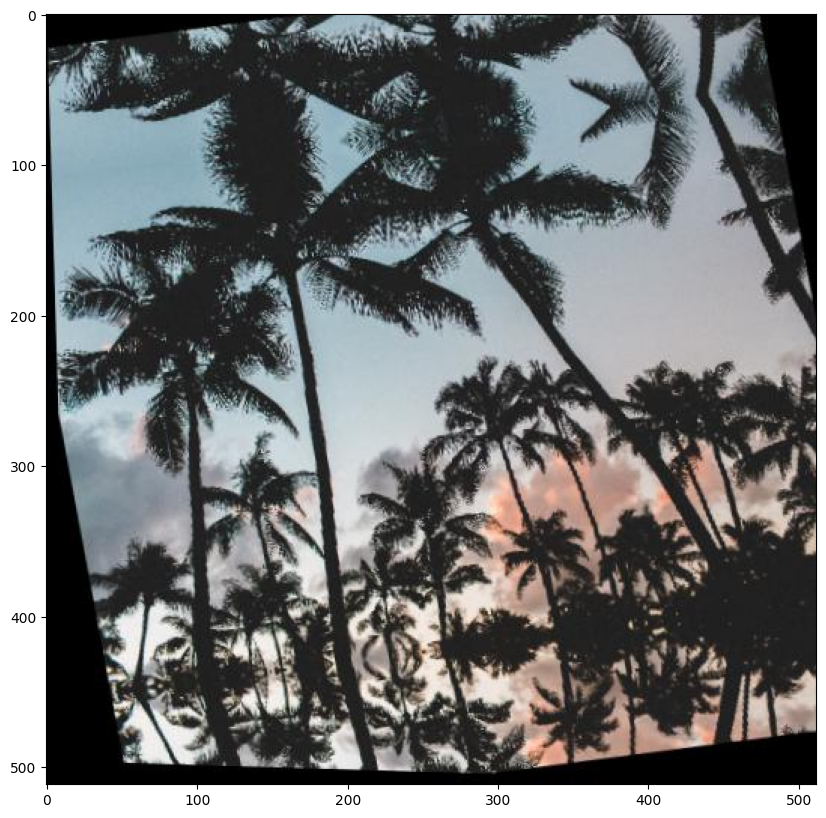

In [ ]:
CLASS_NAMES91 = ['background', 'person', 'bike', 'auto', 'motorbike', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'hydrant' , 'sign', 'stop sign', 'parking clock', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', ' zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoes', 'glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard' , 'sports ball', 'flying kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hotdog', 'pizza', 'doughnut', 'cake', 'chair ', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'table', 'toilet', 'door', 'tv', 'laptop', 'mouse' , 'remote control', 'keyboard', 'mobile phone', 'microwave oven', 'oven', 'toaster', 'dishwasher', 'refrigerator', 'smoothie', 'book', 'clock', 'vase' , 'scissors', 'teddy bear', 'hair dryer', 'toothbrush', 'comb']

model = maskrcnn_resnet50_fpn(weights='DEFAULT')
model.to(device)
model.eval()  # Set the model to evaluation mode

# Function to convert image tensor to PIL
def tensor_to_PIL(image):
    return T.ToPILImage()(image).convert('RGB')

# Get a random image and target from the data loader
images, targets = next(iter(data_loader_train))
image = images[random.randint(0, len(images) - 1)]
image_pil = tensor_to_PIL(image)  # Convert to PIL for visualization

# Move image to the same device as the model
image = image.to(device)

with torch.no_grad():
    prediction = model([image])

# Function to visualize the image and the model predictions
def show_prediction(image_pil, prediction):
    plt.figure(figsize=(10, 10))
    plt.imshow(image_pil)

    for element in range(len(prediction[0]['boxes'])):
        box = prediction[0]['boxes'][element].cpu().numpy()
        score = prediction[0]['scores'][element].item()  # Confidence score of the prediction
        label = prediction[0]['labels'][element].item()  # Class label
        label_name = CLASS_NAMES91[label]  # Requires a mapping from COCO label IDs to class names

        # Draw the bounding box
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)

        # Display the label and score
        plt.gca().text(box[0], box[1], f'{label_name}: {score:.2f}', color='white', fontsize=12, backgroundcolor='red')

    plt.show()

show_prediction(image_pil, prediction)


# Step 5: Build the Model

Modify the build_model function to suit the number of classes in the dataset (background and palm tree).

In [ ]:
def build_model(num_classes):
    # Load a pre-trained model
    model = maskrcnn_resnet50_fpn(weights='DEFAULT')

    # Replace the classifier and mask predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)

    return model

# Assuming two classes (background and palm tree)
model = build_model(2)

# Step 6: Train the Model

Set up the optimizer, learning rate scheduler, and training loop.

In [ ]:
model = model.to(device)

train_loss_dict_t = {}
train_loss_dict_t['loss_classifier']=0
train_loss_dict_t['loss_box_reg']=0
train_loss_dict_t['loss_objectness']=0
train_loss_dict_t['loss_rpn_box_reg']=0

# SGD or Adam
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning Rate Scheduler (Optional): A learning rate scheduler can help adjust the learning rate during training to improve convergence.
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training Loop
# number of epochs
num_epochs = 10
hist_train_classifier=[]
hist_valid_classifier=[]
hist_train_box_reg=[]
hist_valid_box_reg=[]
hist_train_objectness=[]
hist_valid_objectness=[]
hist_train_rpn_box_reg=[]
hist_valid_rpn_box_reg=[]

best_loss=float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_tolerant_count=0
early_stop_tolerant=10;

for epoch in range(num_epochs):
    model.train()
    train_loss_dict_t = {}
    train_loss_dict_t['loss_classifier']=0
    train_loss_dict_t['loss_box_reg']=0
    train_loss_dict_t['loss_objectness']=0
    train_loss_dict_t['loss_rpn_box_reg']=0
    train_losses_t=0
    for images, targets in data_loader_train:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        train_loss_dict = model(images, targets)
        
        train_losses = sum(loss for loss in train_loss_dict.values())
        train_loss_dict_t={x: train_loss_dict_t.get(x, 0) + train_loss_dict.get(x, 0)/len_train*batch_size  for x in set(train_loss_dict)}
        train_losses_t=train_losses_t+train_losses 
        optimizer.zero_grad()
        train_losses.backward()
        optimizer.step()
        
        if lr_scheduler is not None:
            lr_scheduler.step()
            
    # Validation
    
    with torch.no_grad():        # model.eval() would give different output
        valid_loss_dict_t = {}
        valid_loss_dict_t['loss_classifier']=0
        valid_loss_dict_t['loss_box_reg']=0
        valid_loss_dict_t['loss_objectness']=0
        valid_loss_dict_t['loss_rpn_box_reg']=0
        valid_losses_t=0
        for images, targets in data_loader_val:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            valid_loss_dict = model(images, targets)
            
            valid_losses = sum(loss for loss in valid_loss_dict.values())
            valid_loss_dict_t={x: valid_loss_dict_t.get(x, 0) + valid_loss_dict.get(x, 0)/len_valid*batch_size  for x in set(valid_loss_dict)}
            valid_losses_t=valid_losses_t+valid_losses  
        valid_losses0=valid_losses/len_valid*batch_size 
        hist_train_classifier.append(np.array(train_loss_dict_t['loss_classifier'].cpu().detach()))
        hist_valid_classifier.append(np.array(valid_loss_dict_t['loss_classifier'].cpu().detach()))
        hist_train_box_reg.append(np.array(train_loss_dict_t['loss_box_reg'].cpu().detach()))
        hist_valid_box_reg.append(np.array(valid_loss_dict_t['loss_box_reg'].cpu().detach()))
        hist_train_objectness.append(np.array(train_loss_dict_t['loss_objectness'].cpu().detach()))
        hist_valid_objectness.append(np.array(valid_loss_dict_t['loss_objectness'].cpu().detach()))
        hist_train_rpn_box_reg.append(np.array(train_loss_dict_t['loss_rpn_box_reg'].cpu().detach()))
        hist_valid_rpn_box_reg.append(np.array(valid_loss_dict_t['loss_rpn_box_reg'].cpu().detach()))

        # Always save the current best model based on the validation data, and stop the training if no improvements happen after a certain epoch.    
        early_stop_tolerant_count=early_stop_tolerant_count+1
        if valid_losses_t < best_loss:
            early_stop_tolerant_count=0
            best_loss = valid_losses_t
            best_model_wts = copy.deepcopy(model.state_dict())
        if early_stop_tolerant_count>=early_stop_tolerant:
            break 
        if epoch % 1 != 0:
            continue       
        # Display some information along the training
        print("Epoch: ", epoch, ".") 
        print("Training losses: ")
        print("Classifier loss: ", format(train_loss_dict_t['loss_classifier'].item(), ".2f"))
        print("Box regression loss: ", format(train_loss_dict_t['loss_box_reg'].item(), ".2f"))
        print("Objectness loss: ", format(train_loss_dict_t['loss_objectness'].item(), ".2f"))
        print("RPN box regression loss: ", format(train_loss_dict_t['loss_rpn_box_reg'].item(), ".2f"))
        print("Validation losses: ")
        print("Classifier loss: ", format(valid_loss_dict_t['loss_classifier'].item(), ".2f"))
        print("Box regression loss: ", format(valid_loss_dict_t['loss_box_reg'].item(), ".2f"))
        print("Objectness loss: ", format(valid_loss_dict_t['loss_objectness'].item(), ".2f"))
        print("RPN box regression loss: ", format(valid_loss_dict_t['loss_rpn_box_reg'].item(), ".2f"))



AttributeError: 'list' object has no attribute 'items'